In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Click the button on top that says, `Open in Colab`, to run this notebook as a Colab. Running the notebook on your local machine might result in some of the code blocks throwing errors.

In [1]:
# In this exercise you will train a CNN on the FULL Cats-v-dogs dataset
# This will require you doing a lot of data preprocessing because
# the dataset isn't split into training and validation for you
# This code block has all the required inputs
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [2]:
# This code block downloads the full Cats-v-Dogs dataset and stores it as 
# cats-and-dogs.zip. It then unzips it to /tmp
# which will create a tmp/PetImages directory containing subdirectories
# called 'Cat' and 'Dog' (that's how the original researchers structured it)
# If the URL doesn't work, 
# .   visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2021-10-06 20:57:02--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.193.24.126, 2600:1417:76:495::e59, 2600:1417:76:49f::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.193.24.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   162MB/s    in 4.8s    

2021-10-06 20:57:07 (164 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [3]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output:
# 12501
# 12501

12501
12501


In [4]:
# Use os.mkdir to create your directories
# You will need a directory for cats-v-dogs, and subdirectories for training
# and testing. These in turn will need subdirectories for 'cats' and 'dogs'
try:
    classes = ['cats','dogs']
    for class_name in classes:
        os.makedirs(os.path.join("/tmp/cats-v-dogs", "training", class_name))
        os.makedirs(os.path.join("/tmp/cats-v-dogs", "testing", class_name))
except OSError:
    pass

In [7]:
# Write a python function called split_data which takes
# a SOURCE directory containing the files
# a TRAINING directory that a portion of the files will be copied to
# a TESTING directory that a portion of the files will be copie to
# a SPLIT SIZE to determine the portion
# The files should also be randomized, so that the training set is a random
# X% of the files, and the test set is the remaining files
# SO, for example, if SOURCE is PetImages/Cat, and SPLIT SIZE is .9
# Then 90% of the images in PetImages/Cat will be copied to the TRAINING dir
# and 10% of the images will be copied to the TESTING dir
# Also -- All images should be checked, and if they have a zero file length,
# they will not be copied over
#
# os.listdir(DIRECTORY) gives you a listing of the contents of that directory
# os.path.getsize(PATH) gives you the size of the file
# copyfile(source, destination) copies a file from source to destination
# random.sample(list, len(list)) shuffles a list
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  
  ### START YOUR CODE HERE
  # get all the possible files in that Source 
  final_files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
      final_files.append(filename)
    else:
      print(filename + " is zero length, so ignoring.")

  training_length = int(len(final_files) * SPLIT_SIZE)
  testing_length = int(len(final_files) - training_length)

  #suffel Them 
  shuffled = random.sample(final_files, len(final_files))
  train_data = shuffled[0:training_length]
  test_data = shuffled[-testing_length:]

  for filename in train_data:
    current_file = SOURCE + filename
    destination = TRAINING + filename
    copyfile(current_file, destination)

  for filename in test_data:
    current_file = SOURCE + filename
    destination = TESTING + filename
    copyfile(current_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [8]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# Expected output:
# 11250
# 11250
# 1250
# 1250

11250
11250
1250
1250


In [10]:
# DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
# USE AT LEAST 3 CONVOLUTION LAYERS
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.) 
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

Note: You can ignore the `UserWarning: Possibly corrupt EXIF data.` warnings.

In [12]:
history = model.fit(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator)

# The expectation here is that the model will train, and that accuracy will be > 95% on both training and validation
# i.e. acc:A1 and val_acc:A2 will be visible, and both A1 and A2 will be > .9

Epoch 1/15
161/225 [====================>.........] - ETA: 21s - loss: 0.8518 - accuracy: 0.5998

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

225/225 [==============================] - 117s 381ms/step - loss: 0.7773 - accuracy: 0.6245 - val_loss: 0.5646 - val_accuracy: 0.7024
Epoch 2/15
225/225 [==============================] - 86s 383ms/step - loss: 0.5398 - accuracy: 0.7273 - val_loss: 0.5116 - val_accuracy: 0.7376
Epoch 3/15
225/225 [==============================] - 86s 381ms/step - loss: 0.4633 - accuracy: 0.7801 - val_loss: 0.5732 - val_accuracy: 0.7372
Epoch 4/15
225/225 [==============================] - 85s 377ms/step - loss: 0.4028 - accuracy: 0.8167 - val_loss: 0.5255 - val_accuracy: 0.7504
Epoch 5/15
225/225 [==============================] - 84s 373ms/step - loss: 0.3360 - accuracy: 0.8498 - val_loss: 0.4270 - val_accuracy: 0.8160
Epoch 6/15
225/225 [==============================] - 84s 374ms/step - loss: 0.2778 - accuracy: 0.8823 - val_loss: 0.7064 - val_accuracy: 0.7080
Epoch 7/15
225/225 [==============================] - 85s 380ms/step - loss: 0.2075 - accuracy: 0.9159 - val_loss: 0.5359 - val_accuracy: 0.

Text(0.5, 1.0, 'Training and validation loss')

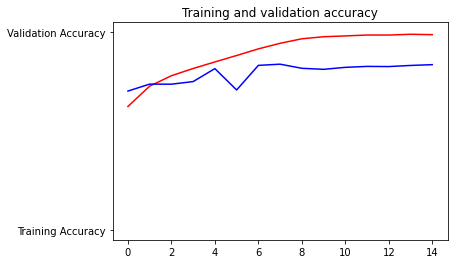

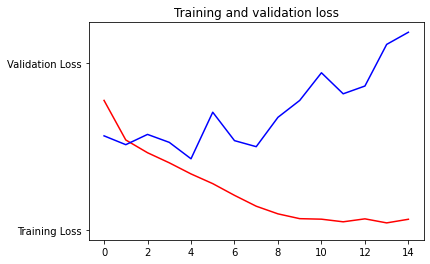

In [13]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

**Important Note:** Due to some compatibility issues, the following code block will result in an error after you select the images(s) to upload if you are running this notebook as a `Colab` on the `Safari` browser. For `all other broswers`, continue with the next code block and ignore the next one after it.

The ones running the `Colab` on `Safari`, comment out the code block below, uncomment the next code block and run it.

In [14]:
# # Here's a codeblock just for fun. You should be able to upload an image here 
# # and have it classified without crashing

# import numpy as np
# from google.colab import files
# from keras.preprocessing import image

# uploaded = files.upload()

# for fn in uploaded.keys():
 
#   # predicting images
#   path = '/content/' + fn
#   img = image.load_img(path, target_size=(# YOUR CODE HERE))
#   x = image.img_to_array(img)
#   x = np.expand_dims(x, axis=0)

#   images = np.vstack([x])
#   classes = model.predict(images, batch_size=10)
#   print(classes[0])
#   if classes[0]>0.5:
#     print(fn + " is a dog")
#   else:
#     print(fn + " is a cat")

For those running this `Colab` on `Safari` broswer can upload the images(s) manually. Follow the instructions, uncomment the code block below and run it.

Instructions on how to upload image(s) manually in a Colab:

1. Select the `folder` icon on the left `menu bar`.
2. Click on the `folder with an arrow pointing upwards` named `..`
3. Click on the `folder` named `tmp`.
4. Inside of the `tmp` folder, `create a new folder` called `images`. You'll see the `New folder` option by clicking the `3 vertical dots` menu button next to the `tmp` folder.
5. Inside of the new `images` folder, upload an image(s) of your choice, preferably of either a horse or a human. Drag and drop the images(s) on top of the `images` folder.
6. Uncomment and run the code block below. 

In [15]:
# import numpy as np
# from keras.preprocessing import image
# import os

# images = os.listdir("/tmp/images")

# print(images)

# for i in images:
#  print()
#  # predicting images
#  path = '/tmp/images/' + i
#  img = image.load_img(path, target_size=(150, 150))
#  x = image.img_to_array(img)
#  x = np.expand_dims(x, axis=0)

#  images = np.vstack([x])
#  classes = model.predict(images, batch_size=10)
#  print(classes[0])
#  if classes[0]>0.5:
#    print(i + " is a dog")
#  else:
#    print(i + " is a cat")

Model From The internet (kaggle)[]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) # 2 because we have cat and dog classes

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]


epochs = 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)       

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
 27/225 [==>...........................] - ETA: 1:36 - loss: 1.0387 - accuracy: 0.5971